In [1]:
import sys
from dotenv import dotenv_values
import binance
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [2]:
print(sys.version)
print(f'Binance client: {binance.__version__}')
print(f'Pandas verrsion: {pd.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'Seaborn version: {sns.__version__}')

3.10.8 (main, Oct 12 2022, 09:46:29) [Clang 14.0.0 (clang-1400.0.29.102)]
Binance client: 1.0.16
Pandas verrsion: 1.5.1
Matplotlib version: 3.6.2
Seaborn version: 0.12.1


In [3]:
sns.set_style('whitegrid')
sns.set_context("paper")
config = dotenv_values('env')

In [4]:
api_key = config.get('API_KEY')
secret_key = config.get('SECRET_KEY')
binance_client = binance.Client(api_key, secret_key)
timestamp = binance_client.get_server_time()["serverTime"]
print(f'Server time: {timestamp} ~ {datetime.fromtimestamp(timestamp / 1000)}')

Server time: 1669043336260 ~ 2022-11-21 22:08:56.260000


In [5]:
tickers = binance_client.get_ticker()
tickers = pd.DataFrame(tickers)
tickers = tickers.astype({'symbol': 'str', 'lastPrice': 'float64'})
tickers = tickers[tickers['symbol'].str.endswith('BUSD')]
tickers = tickers.assign(asset=lambda r: r.symbol.str[:-4])
tickers.reset_index(drop=True, inplace=True)

In [6]:
info = binance_client.get_account()

In [7]:
balances = pd.DataFrame(info['balances'])
balances = balances.astype({'asset': 'str', 'free': 'float64', 'locked': 'float64'})
balances = balances.loc[(balances['free'] > 0) | (balances['locked'] > 0)]
balances = balances.assign(total=lambda r: r.free + r.locked)
balances = balances[balances['asset'] != 'NFT']
for index, balance in balances.iterrows():
    try:
        price = tickers[tickers['asset'] == balance['asset']]['lastPrice'].iloc[0]
        balances.at[index, ['free', 'locked', 'total']] = balance[['free', 'locked', 'total']] * price
    except Exception as ex:
        pass
balances.reset_index(drop=True, inplace=True)

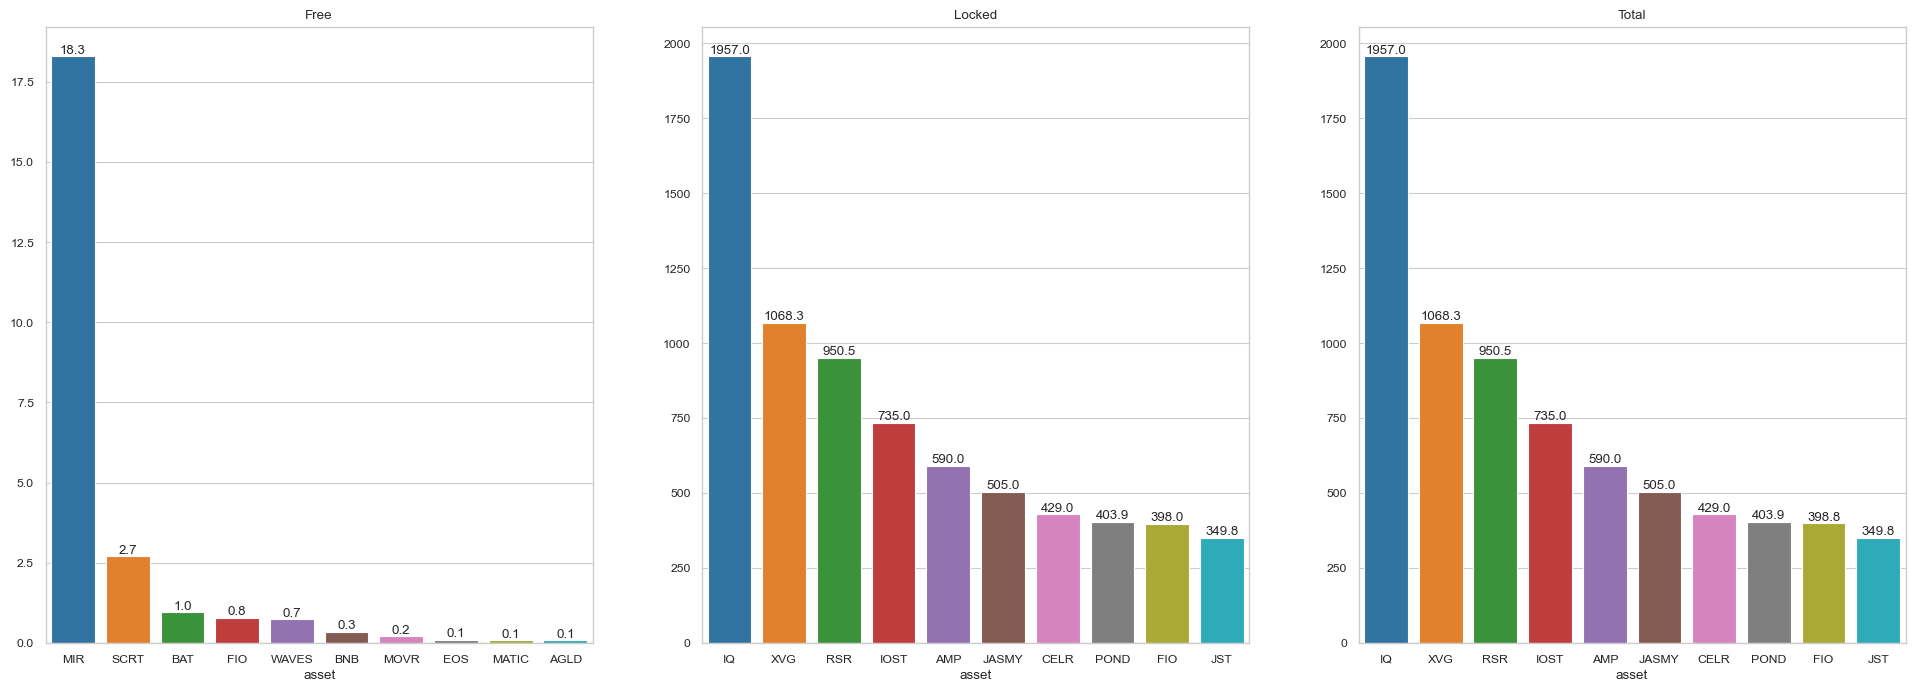

In [8]:
%matplotlib inline
top = 10
figure, axes = plt.subplots(1, 3, figsize=(24,8))
df = balances.sort_values(by='free', ascending=False)[:top]
sns.barplot(ax=axes[0], data=df, x='asset', y='free').set(title='Free', ylabel=None)
for bars in axes[0].containers:
    axes[0].bar_label(bars, fmt='%.1f')
df = balances.sort_values(by='locked', ascending=False)[:top]
sns.barplot(ax=axes[1], data=df, x='asset', y='locked').set(title='Locked', ylabel=None)
for bars in axes[1].containers:
    axes[1].bar_label(bars, fmt='%.1f')
df = balances.sort_values(by='total', ascending=False)[:top]
sns.barplot(ax=axes[2], data=df, x='asset', y='total').set(title='Total', ylabel=None)
for bars in axes[2].containers:
    axes[2].bar_label(bars, fmt='%.1f')
plt.show()